<h1><center>CS3111 - Introduction to Machine Learning</center>
<center>Lab 01 -Feature Engineering</center></h1>

Index:  210170G<br>
Name:   W.A.R.T.Fonseka

In [4]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.feature_selection import RFE, f_classif
from sklearn.model_selection import cross_val_score

In [5]:
dataset = pd.read_csv("train.csv")
df = pd.DataFrame(dataset)
print(df.shape)

(517788, 145)


<h3>1. Data cleaning</h3>

<h5>1.1 Remove duplicate rows</h5>

In [6]:
df = df.drop_duplicates()
print(df.shape)

(517788, 145)


We can see that there are no duplicates. Next, let's examine the situation regarding missing values.

<h5>1.2 Remove features with more missing values</h5>

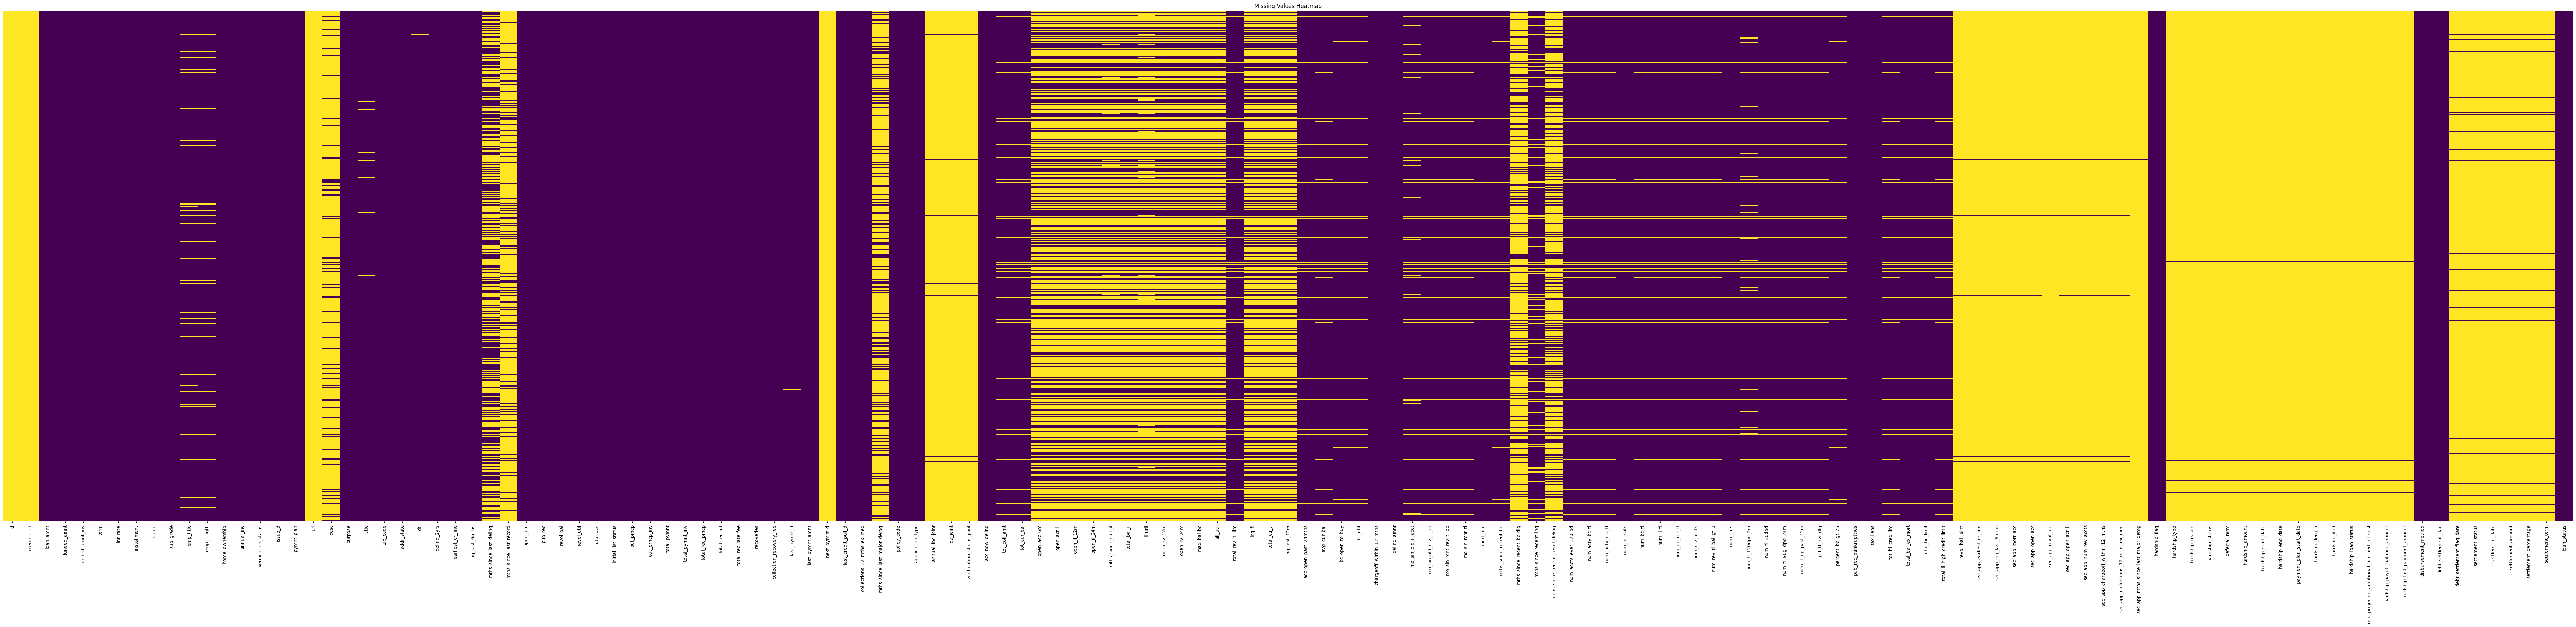

In [7]:
plt.figure(figsize=(100,20))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

We can observe that many features have a large number of missing values. Therefore, I will remove features with missing values that exceed a threshold of 0.5, meaning those with half or more missing values.

In [8]:
threshold = 0.5
df = df.dropna(axis=1, thresh=len(df)*0.5)
df.shape

(517788, 87)

<h5>1.3 Fill missing values</h5>

I will not fill all features with missing values, as some features are correlated with each other and I will remove them later. Instead, I will focus on the more important features. Additionally, I can calculate values for some missing values using these correlated features.

First we find feature with missing values and there misisng value count.

In [9]:
columns_with_null_values = df.columns[df.isnull().any()].tolist()
count = 0
for name in columns_with_null_values:
    length = len(df[df[name].isnull()][name])
    count += length
    print(name, length)
print('Total missing value count', count)

emp_title 34051
emp_length 31300
title 6617
zip_code 1
dti 132
revol_util 321
last_pymnt_d 1360
last_credit_pull_d 20
collections_12_mths_ex_med 19
tot_coll_amt 25879
tot_cur_bal 25879
total_rev_hi_lim 25879
acc_open_past_24mths 17975
avg_cur_bal 25887
bc_open_to_buy 23303
bc_util 23581
chargeoff_within_12_mths 19
mo_sin_old_il_acct 40678
mo_sin_old_rev_tl_op 25879
mo_sin_rcnt_rev_tl_op 25879
mo_sin_rcnt_tl 25879
mort_acc 17975
mths_since_recent_bc 22960
mths_since_recent_inq 64883
num_accts_ever_120_pd 25879
num_actv_bc_tl 25879
num_actv_rev_tl 25879
num_bc_sats 21302
num_bc_tl 25879
num_il_tl 25879
num_op_rev_tl 25879
num_rev_accts 25879
num_rev_tl_bal_gt_0 25879
num_sats 21302
num_tl_120dpd_2m 45690
num_tl_30dpd 25879
num_tl_90g_dpd_24m 25879
num_tl_op_past_12m 25879
pct_tl_nvr_dlq 25950
percent_bc_gt_75 23464
pub_rec_bankruptcies 250
tax_liens 11
tot_hi_cred_lim 25879
total_bal_ex_mort 17975
total_bc_limit 17975
total_il_high_credit_limit 25879
Total missing value count 976702


We can calculate missing values for 'dti' using other features (dti = monthly debt payment / annual income). Some 'dti' values are null because the annual income is 0. In reality, these values go to infinity. Since we cannot store infinity, we fill null values with the (max(dti) + 1000).

In [10]:
df[df['dti'].isnull()][['dti', 'annual_inc']].head()

,dti,annual_inc
6409,NaN,0.0
7569,NaN,0.0
15362,NaN,0.0
24367,NaN,0.0
26053,NaN,0.0


In [11]:
df['dti'] = df['dti'].fillna(df['dti'].max()+1000)

I calculated missing values for 'revol_util' using the formula (revol_bal / total_rev_hi_lim) * 100. However, there are still missing values because the 'total_rev_hi_lim' value is 0. For these values, we fill with the (max(revol_util)+1000)

In [12]:
df['revol_util'] = df['revol_util'].fillna((df['revol_bal'] / df['total_rev_hi_lim'])*100)
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].max()+1000)

Let's plot charts for some features and examine what kind of data they have.

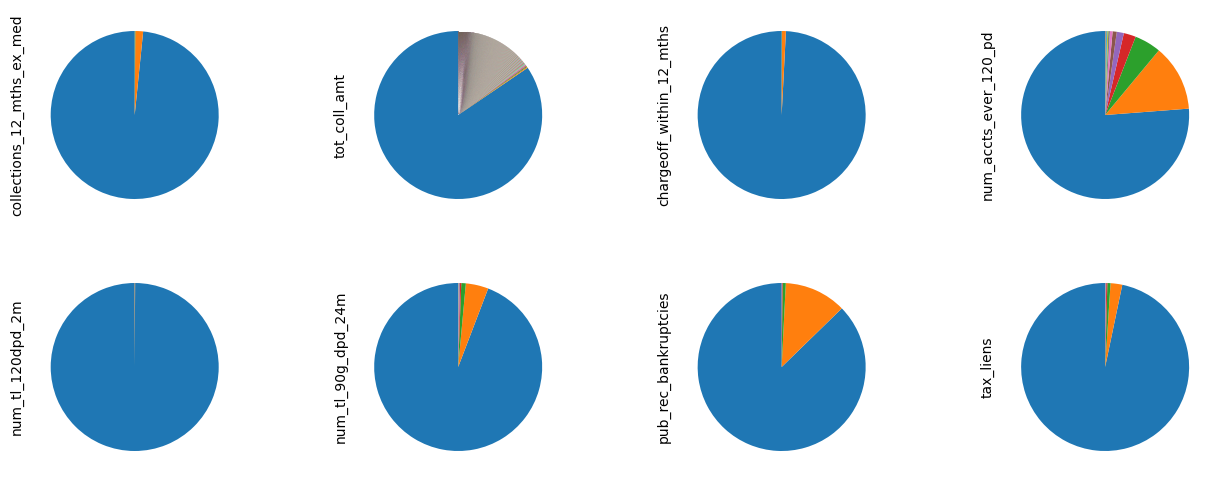

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

df['collections_12_mths_ex_med'].value_counts().plot.pie(ax=axes[0,0], labels=None, startangle=90)
axes[0,0].set_ylabel('collections_12_mths_ex_med')
df['tot_coll_amt'].value_counts().plot.pie(ax=axes[0,1], labels=None, startangle=90)
axes[0,1].set_ylabel('tot_coll_amt')
df['chargeoff_within_12_mths'].value_counts().plot.pie(ax=axes[0,2], labels=None, startangle=90)
axes[0,2].set_ylabel('chargeoff_within_12_mths')
df['num_accts_ever_120_pd'].value_counts().plot.pie(ax=axes[0,3], labels=None, startangle=90)
axes[0,3].set_ylabel('num_accts_ever_120_pd')
df['num_tl_120dpd_2m'].value_counts().plot.pie(ax=axes[1,0], labels=None, startangle=90)
axes[1,0].set_ylabel('num_tl_120dpd_2m')
df['num_tl_90g_dpd_24m'].value_counts().plot.pie(ax=axes[1,1], labels=None, startangle=90)
axes[1,1].set_ylabel('num_tl_90g_dpd_24m')
df['pub_rec_bankruptcies'].value_counts().plot.pie(ax=axes[1,2], labels=None, startangle=90)
axes[1,2].set_ylabel('pub_rec_bankruptcies')
df['tax_liens'].value_counts().plot.pie(ax=axes[1,3], labels=None, startangle=90)
axes[1,3].set_ylabel('tax_liens')

plt.show()

We can see that most of the values are 0. Therefore, filling missing values with 0 should not cause much harm. My assumption was that null values represent the value 0. Sometimes, when we do not have certain data, we leave it empty instead of putting 0.

In [14]:
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].fillna(0)
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)
df['chargeoff_within_12_mths'] = df['chargeoff_within_12_mths'].fillna(0)
df['num_accts_ever_120_pd'] = df['num_accts_ever_120_pd'].fillna(0)
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0)
df['num_tl_90g_dpd_24m'] = df['num_tl_90g_dpd_24m'].fillna(0)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)
df['tax_liens'] = df['tax_liens'].fillna(0)

In [15]:
#Example for see value counts for features
df['tot_cur_bal'].value_counts()

tot_cur_bal
0.0         153
25981.0      15
31799.0      14
23372.0      14
21181.0      14
           ... 
373218.0      1
659009.0      1
326162.0      1
353254.0      1
165260.0      1
Name: count, Length: 250661, dtype: int64

Since some data is not mentioned, it may lead to the rejection of loan requests and there exits null value because custuner never had that data.It is important to reprecent that kind of data in specific way. Filling missing values with a specific value could harm the dataset(because missing value count is too high). I fill missing values with a non-existent data value, such as -1, for such features. The advantage is that we can represent null values as -1, which may help the model perform better.

In [16]:
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(-1)
df['acc_open_past_24mths'] = df['acc_open_past_24mths'].fillna(-1)
df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(-1)
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].fillna(-1)
df['mo_sin_rcnt_rev_tl_op'] = df['mo_sin_rcnt_rev_tl_op'].fillna(-1)
df['mo_sin_rcnt_tl'] = df['mo_sin_rcnt_tl'].fillna(-1)
df['mort_acc'] = df['mort_acc'].fillna(-1)
df['mths_since_recent_bc'] = df['mths_since_recent_bc'].fillna(-1)
df['mths_since_recent_inq'] = df['mths_since_recent_inq'].fillna(-1)
df['num_actv_bc_tl'] = df['num_actv_bc_tl'].fillna(-1)
df['num_bc_tl'] = df['num_bc_tl'].fillna(-1)
df['num_il_tl'] = df['num_il_tl'].fillna(-1)
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].fillna(-1)
df['total_bc_limit'] = df['total_bc_limit'].fillna(-1)
df['total_bal_ex_mort'] = df['total_bal_ex_mort'].fillna(-1)

Assume that missing values in datetime features indicate that the datetime is far in the past. Therefore, fill them with a value older than the oldest value of that feature.(use Jan-1960)

In [17]:
df['last_pymnt_d'] = df['last_pymnt_d'].fillna('Jan-1960')

df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna('Jan-1960')

<h5>1.4 Data transformation</h5>

Change the 'issue date' feature to 'issue year', because in banking, the most important aspect is the issue year, not the actual day.

In [18]:
df['issue_d'] = df['issue_d'].str.extract('(\d{4})')
df['issue_d'] = df['issue_d'].astype(int)

In a similar manner and for similar reasons, we can convert the 'zip_code' values.

In [19]:
df['zip_code'].value_counts().head()

zip_code
945xx    5855
750xx    5539
112xx    5414
606xx    4671
300xx    4535
Name: count, dtype: int64

In features with datetime, I replaced the dates with how many months older they are compared to the current date. Otherwise, the model may think it depends on the year, but it actually depends on how much time has passed from then to now.

In [20]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
current_date = datetime.datetime.now()
df['earliest_cr_line'] = (((current_date - df['earliest_cr_line']).dt.days)/30)
df['earliest_cr_line'] = df['earliest_cr_line'].astype(int)

df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
current_date = datetime.datetime.now()
df['last_pymnt_d'] = (((current_date - df['last_pymnt_d']).dt.days)/30)
df['last_pymnt_d'] = df['last_pymnt_d'].astype(int)

df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y')
current_date = datetime.datetime.now()
df['last_credit_pull_d'] = (((current_date - df['last_credit_pull_d']).dt.days)/30)
df['last_credit_pull_d'] = df['last_credit_pull_d'].astype(int)

In [21]:
df['zip_code'] = df['zip_code'].str.replace('xx','')
df['zip_code'] = df['zip_code'].fillna(0)
df['zip_code'] = df['zip_code'].astype(int)

<h5>1.5 Remove data that is not useful</h5>

In [22]:
df['pymnt_plan'].unique()

array(['n'], dtype=object)

We can see that all the data in the feature are the same. This type of data is not useful for training the machine learning model. Therefore, we should remove it.

In [23]:
df = df.drop(columns=['pymnt_plan'])

df = df.drop(columns=['hardship_flag'])

df = df.drop(columns=['policy_code', 'out_prncp', 'out_prncp_inv'])

<h3>2. Feature encoding</h3>

I use Label Encoding and Ordinal Encoding because we want to minimize the number of features. Instead, using technique like One-Hot Encoding increases the number of features. In this situation, it's not harmful to use Label Encoding and Ordinal Encoding suitable way.

<h5>2.1 Label Encoding</h5>

In [24]:
label_encoder = LabelEncoder()
df['term'] = label_encoder.fit_transform(df['term'])

df['home_ownership'] = label_encoder.fit_transform(df['home_ownership'])

df['purpose'] = label_encoder.fit_transform(df['purpose'])

df['addr_state'] = label_encoder.fit_transform(df['addr_state'])

df['initial_list_status'] = label_encoder.fit_transform(df['initial_list_status'])

df['application_type'] = label_encoder.fit_transform(df['application_type'])

df['disbursement_method'] = label_encoder.fit_transform(df['disbursement_method'])

df['debt_settlement_flag'] = label_encoder.fit_transform(df['debt_settlement_flag'])

<h5>2.2 Ordinal Encoding</h5>

In [25]:
mapping = {
    'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
    'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9,
    'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14,
    'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19,
    'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24,
    'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29,
    'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34
}
df['sub_grade'] = df['sub_grade'].replace(mapping)


df['emp_length'] = df['emp_length'].fillna(0) #Null value fill with 0
mapping = {'< 1 year':1, '1 year':2, '2 years':3, '3 years':4, '4 years':5, '5 years':6, '6 years':7, '7 years':8, '8 years':9, '9 years':10, '10+ years':11}
df['emp_length'] = df['emp_length'].replace(mapping)


mapping = {
    'Not Verified': 0,
    'Verified': 1,
    'Source Verified': 2
}
df['verification_status'] = df['verification_status'].replace(mapping)

C:\Users\USER\AppData\Local\Temp\ipykernel_4412\4251108409.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sub_grade'] = df['sub_grade'].replace(mapping)
C:\Users\USER\AppData\Local\Temp\ipykernel_4412\4251108409.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['emp_length'] = df['emp_length'].replace(mapping)
C:\Users\USER\AppData\Local\Temp\ipykernel_4412\4251108409.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly

<h5>2.3 Other data specific method</h5>

In this situation, the employee title is not very important. On the other hand, the data dictionary states that 'Employer Title' replaces 'Employer Name' for all loans listed after 9/23/2013. Therefore, the most important thing is whether the employee title is mentioned or not. I encode this feature such that if the employee title is mentioned, then it is assigned a value of 1; otherwise, it is assigned a value of 0.


In [26]:
df['emp_title'] = df['emp_title'].fillna(0)
df['emp_title'] = df['emp_title'].apply(lambda x: 1 if x != 0 else 0)

Similarly, the 'title' can be anything that the customer provided. The important thing is whether the title exists or not.

In [27]:
df['title'] = df['title'].fillna(0)
df['title'] = df['title'].apply(lambda x: 1 if x != 0 else 0)

<h3>3. Remove correlated features</h3>

We can clearly see that some features are highly correlated with each other, while others are not clearly see. 

'grade' and 'sub_grade' are correlated, so we can remove 'grade' (but not 'sub_grade', as it provides more information than 'grade')

In [28]:
df = df.drop(columns=['grade'])

Now, I will create a correlation matrix and plot it as a heatmap, so that I can recognize correlated features.

In [29]:
correlation_matrix = df.corr()
plt.figure(figsize=(100,100))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

We can see that there are some positively correlated features, but there are no highly negatively correlated features. Therefore, I will remove them by selecting a threshold value of 0.75.

In [30]:
threshold = 0.75
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

df = df.drop(columns=highly_correlated_features)

In [31]:
df.shape

(517788, 57)

Now that I have completed data preprocessing, I will run the following code to ensure that there are no more missing values and NaN values.

In [32]:
columns_with_nan_values = df.columns[df.isna().any()].tolist()
print(columns_with_nan_values)

columns_with_null_values = df.columns[df.isnull().any()].tolist()
print(columns_with_null_values)

[]
[]


<h3>3. Feature selection</h3>

I chose the Recursive Feature Elimination method to select the best features. I ran this code segment multiple times with different values for the 'n_features_to_select' parameter and found the minimum number of best features with high accuracy. However, the output only shows my final results.

In [33]:
y_train = df['loan_status']
X_train = df.drop(columns=['loan_status'])

xgb_model = XGBClassifier()

from sklearn.feature_selection import RFE, f_classif
from sklearn.model_selection import cross_val_score

feature_selector = RFE(estimator=xgb_model, n_features_to_select=8, verbose=2) 
feature_selector.fit(X_train, y_train)
selected_features = X_train.columns[feature_selector.support_]
scores = cross_val_score(xgb_model, feature_selector.transform(X_train), y_train, cv=5, scoring='accuracy')
(f"Selected features: {selected_features}, Performance score: {np.mean(scores):.4f}")

Fitting estimator with 56 features.


Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 fe

"Selected features: Index(['loan_amnt', 'term', 'issue_d', 'total_rec_late_fee', 'recoveries',\n       'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag'],\n      dtype='object'), Performance score: 0.9879"

In [34]:
print(selected_features)
X_train = X_train[selected_features]

Index(['loan_amnt', 'term', 'issue_d', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag'],
      dtype='object')


<h3>4. Dimensionality Reduction</h3>

When I used PCA as a dimensionality reduction technique, my model's accuracy decreased because reducing more features can lead to missing some important attributes. So, I did not apply PCA for our model. On the other hand, I don't want much because our feature count is low, which is 8.

In [35]:
# X_train = X_train[selected_features]

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# pca = PCA(n_components=7)
# pca.fit(X_train_scaled)
# X_train_pca = pca.transform(X_train_scaled)

# print(pca.explained_variance_ratio_)

<h3>5. Hyperparameter Tuning</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

<h3>6. Model train</h5>

Now, we can train our model using 'X_train' and 'y_train'.

In [ ]:
xgb_model = grid_search.best_estimator_
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<h3>7. Data validation</h3>

Now, we need to validate our model and change some parameters if necessary.

<h5>7.1 Read and prepare validation dataset</h5>

In [ ]:
dataset_valid = pd.read_csv("valid.csv")
df_valid = pd.DataFrame(dataset_valid)
print(df_valid.shape)

(172596, 145)


In [ ]:
df_valid['term'] = label_encoder.fit_transform(df_valid['term'])

df_valid['issue_d'] = df_valid['issue_d'].str.extract('(\d{4})')
df_valid['issue_d'] = df_valid['issue_d'].astype(int)

df_valid['last_pymnt_d'] = df_valid['last_pymnt_d'].fillna('Jan-1960')
df_valid['last_pymnt_d'] = pd.to_datetime(df_valid['last_pymnt_d'], format='%b-%Y')
current_date = datetime.datetime.now()
df_valid['last_pymnt_d'] = (((current_date - df_valid['last_pymnt_d']).dt.days)/30)
df_valid['last_pymnt_d'] = df_valid['last_pymnt_d'].astype(int)

df_valid['debt_settlement_flag'] = label_encoder.fit_transform(df_valid['debt_settlement_flag'])

<h5>7.2 Predict loan status for validation data</h5>

In [ ]:
y_valid = df_valid['loan_status']
X_valid = df_valid[selected_features]

y_pred = xgb_model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


<h3>8. SHAP analysis for explainable AI</h3>

In [ ]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_valid)

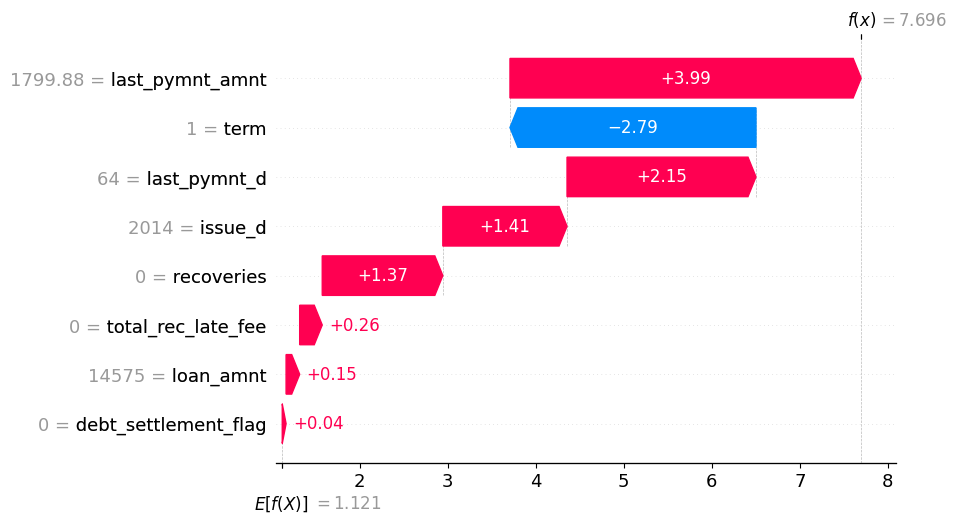

In [ ]:
shap.plots.waterfall(shap_values[0])

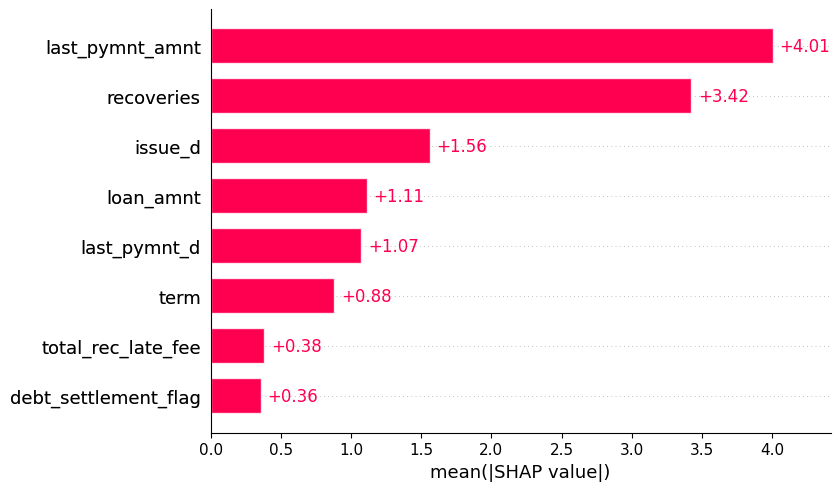

In [ ]:
shap_values = explainer(X_valid)
shap.plots.bar(shap_values)

<h3>Predict target label for test data</h3>

In [ ]:
dataset_test = pd.read_csv("X_valid.csv")
df_test = pd.DataFrame(dataset_test)
print(df_test.shape)

In [ ]:
df_test['term'] = label_encoder.fit_transform(df_test['term'])

df_test['issue_d'] = df_test['issue_d'].str.extract('(\d{4})')
df_test['issue_d'] = df_test['issue_d'].astype(int)

df_test['last_pymnt_d'] = df_test['last_pymnt_d'].fillna('Jan-1960')
df_test['last_pymnt_d'] = pd.to_datetime(df_test['last_pymnt_d'], format='%b-%Y')
current_date = datetime.datetime.now()
df_test['last_pymnt_d'] = (((current_date - df_test['last_pymnt_d']).dt.days)/30)
df_test['last_pymnt_d'] = df_test['last_pymnt_d'].astype(int)

df_test['debt_settlement_flag'] = label_encoder.fit_transform(df_test['debt_settlement_flag'])

In [ ]:
X_valid = df_test[selected_features]

y_valid_pred = xgb_model.predict(X_valid)

In [ ]:
output_data = {'loan_status': y_valid_pred}

In [ ]:
output_df = pd.DataFrame(output_data)

In [ ]:
output_df = pd.concat([output_df, X_valid], axis=1)

In [ ]:
output_df

In [ ]:
output_df.to_csv('210170G.csv', index=False)